In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import scale, robust_scale 
from sklearn.cluster import DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [105]:
def read_csv(filename: str) -> []:
    df = pd.read_csv(filename)
    df = df[['budget', 'original_language', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']].dropna(axis=0,how='any')
    return np.array(df)

datas = read_csv('./data/tmdb_5000_movies.csv')

original_language_dict = {}
for data in datas:
    if not original_language_dict.get(data[1]):
        original_language_dict[data[1]] = len(original_language_dict)

for idx, data in enumerate(datas):
    datas[idx][1] = original_language_dict[datas[idx][1]]

datas = datas.astype(np.float32)
datas = scale(datas, axis=1)

print(datas.shape)

print('max', np.max(datas.T, axis=1))
print('min', np.min(datas.T, axis=1))
print('std', np.std(datas.T, axis=1))
print('avg', np.average(datas.T, axis=1))

(4801, 7)
max [2.44949   2.4494898 1.0376213 2.44949   2.4494603 2.4301028 2.445303 ]
min [-0.8830631  -0.90489537 -1.0380327  -0.92598075 -0.8830631  -1.0039402
 -0.67664737]
std [1.0881698  0.17526506 0.08315782 1.2663264  1.0331156  0.17687024
 0.56592894]
avg [ 0.7207959  -0.5104646  -0.51196337  1.1671913  -0.04678602 -0.49256605
 -0.3262071 ]


e:\program files (x86)\python\python36\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
e:\program files (x86)\python\python36\lib\site-packages\sklearn\preprocessing\data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [51]:
# datas = datas[0:2000]
# print(datas)

eps = .1
pts = 2
vis = list(np.zeros(len(datas)))  # 访问记录
clusters = []  # 结果的簇

def getNeighbor(kerIdx, points):
    """
    计算点 point[kerIdx] 在 eps 的领域内的所有点
    """
    return [idx for idx in range(len(points)) if np.linalg.norm(points[kerIdx] - points[idx]) <= eps]  # 点 points[idx] 在 points[kerIdx] 的领域内

import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(len(datas)):
    if vis[i]: continue  # 未访问过
    vis[i] = True
    neighborIdxs = getNeighbor(i, datas)  # 计算 i 的领域
    cluster = []
    if len(neighborIdxs) >= pts:  # i 为核心点
        cluster.append(i)  # 先将 i 添加进簇里面
        for n_idx in neighborIdxs:  # 遍历整个领域
            if vis[n_idx]: continue
            vis[n_idx] = True
            cluster.append(n_idx)  # 领域内的 n_idx 未访问过，加入簇
            # 对 n_idx 获取领域，如果为核心点，则将 n_idx 的领域加入遍历列表中
            n_neighborIdxs = getNeighbor(n_idx, datas)  
            if len(n_neighborIdxs) >= pts:  # 领域内的点为核心点
                neighborIdxs.extend([idx for idx in n_neighborIdxs if idx not in neighborIdxs])  # 不使用递归
    
    if len(cluster) >= pts:
        print('cluster: ', len(cluster))
        clusters.append(cluster)
        
print(len(clusters))

print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-11-23 00:35:33
cluster:  3875
cluster:  831
cluster:  2
cluster:  3
cluster:  8
cluster:  2
cluster:  3
7
2019-11-23 00:41:24


In [101]:
print('datas: ', len(datas), 'noise: ', len(datas) - sum([len(c) for c in clusters]))
xs, ys = [], []
for idx, x in enumerate(datas):
    for cid, c in enumerate(clusters):
        if idx in c:
            xs.append(x)
            ys.append(cid)

from collections import Counter
print(Counter(ys))
xs = np.array(xs)

datas:  4801 noise:  77
Counter({0: 3875, 1: 831, 4: 8, 3: 3, 6: 3, 2: 2, 5: 2})


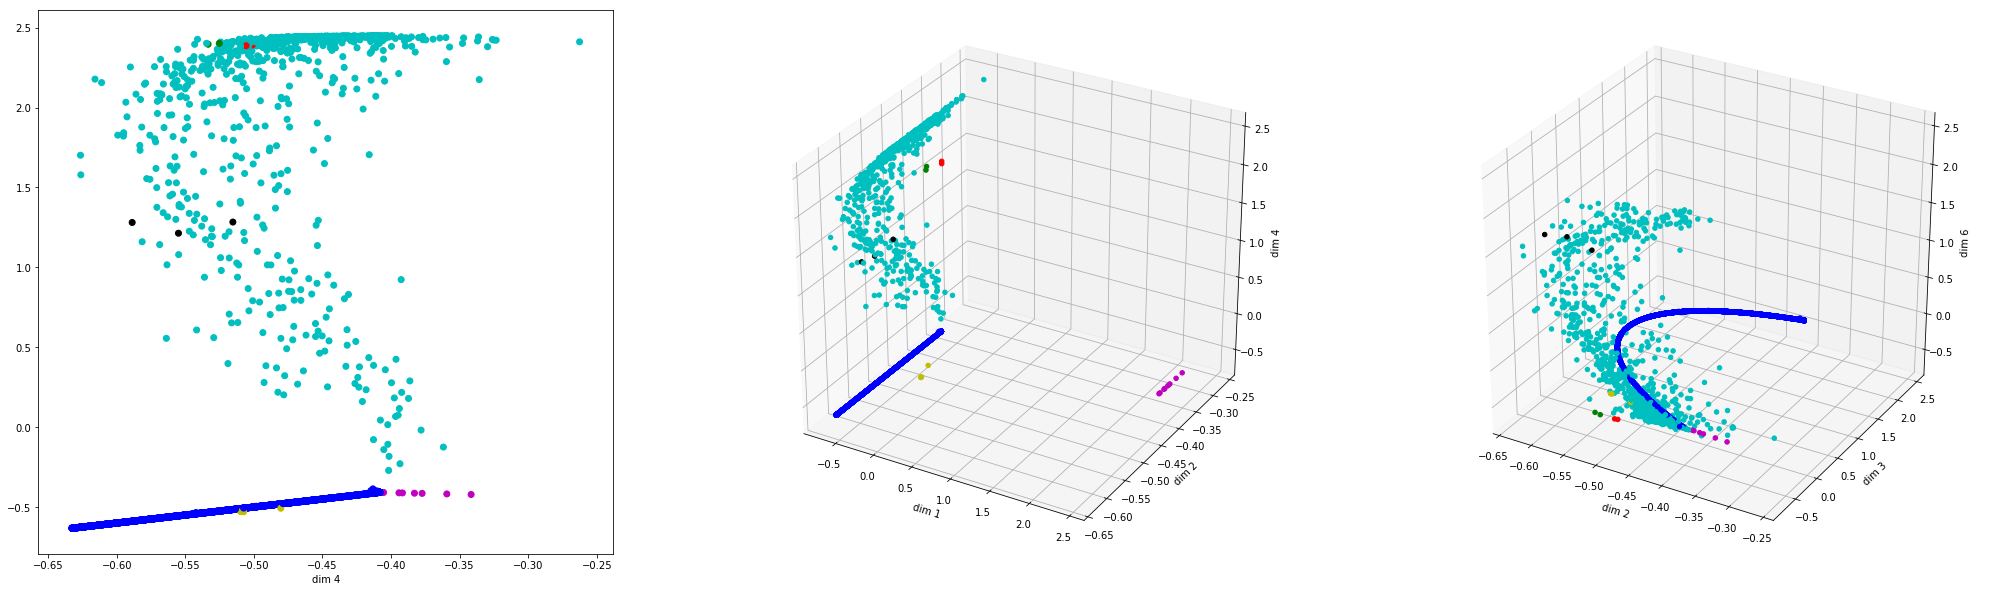

In [112]:
colors = 'bcgkmry'
y_pred = [colors[y] for y in ys]

plt.figure(figsize=(35, 10))
fig = plt.subplot(131)
fig.set_xlabel('dim 2')
fig.set_xlabel('dim 4')
fig.scatter(xs[:, 2], xs[:, 4], c=y_pred)

fig = plt.subplot(132, projection='3d')
fig.set_xlabel('dim 1')
fig.set_ylabel('dim 2')
fig.set_zlabel('dim 4')
fig.scatter(xs[:, 1], xs[:, 2], xs[:, 4], c=y_pred, alpha=1)

fig = plt.subplot(133, projection='3d')
fig.set_xlabel('dim 2')
fig.set_ylabel('dim 3')
fig.set_zlabel('dim 6')
fig.scatter(xs[:, 2], xs[:, 3], xs[:, 6], c=y_pred, alpha=1)

plt.savefig('dbscan.pdf')
plt.show()

In [ ]:
##############3
# 递归的写法

# eps = .1
# pts = 2
# vis = {str(d): False for d in datas}  # 访问记录
# clusters = []  # 结果的簇

# def getNeighbor(point) -> []:
#     """
#     计算点 point 在 eps 的领域内的所有点，包括 point
#     """
#     ret = []
#     for other in datas:
#         if np.linalg.norm(other - point) < eps:  # 点 other 在 point 的领域内
#             ret.append(other)
#     return ret
    
# def calcCluster(point, cluster=[]) -> [[]]:
#     """
#     对单独一个点计算簇
#     """
#     if vis[str(point)]: return cluster
#     vis[str(point)] = True
#     neighbor = getNeighbor(point)  # 计算点 point 的领域
#     if len(neighbor) >= pts:  # 点 point 为核心点
#         cluster.extend(neighbor)
#         cluster = list(np.unique(np.array(cluster), axis=0))  # 将领域内的点插入到簇
#         for point_in_neighbor in neighbor:  # 簇中对未处理过的点 递归求领域
#             if not vis[str(point_in_neighbor)]:
#                 cluster = calcCluster(point_in_neighbor, cluster)
#     return cluster

# for point in datas:  # 对所有点遍历一遍，找到所有簇
#     if vis[str(point)]: continue
#     cluster = calcCluster(point, [])
#     if len(cluster) >= pts:
#         print('cluster: ', len(cluster))
#         clusters.append(cluster)
